<h1>Материалы</h1>

Презентация: в папке проекта
<br>Дашборд: https://public.tableau.com/app/profile/svetlana6178/viz/Metanprombank_16472641453930/sheet1?publish=yes

# Сегментация пользователей «Метанпромбанк» по потреблению

Задача: Проанализировать клиентов регионального банка и сегментировать пользователей по количеству потребляемых продуктов. Проверить гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним. Сформулировать и проверить статистическую гипотезу относительно представленных данных.

**Описание данных:**

- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- Age — возраст,
- Objects — количество объектов в собственности,
- Balance — баланс на счёте,
- Products — количество продуктов, которыми пользуется клиент,
- CreditCard — есть ли кредитная карта,
- Loyalty — активный клиент,
- estimated_salary — заработная плата клиента,
- Churn — ушёл или нет.

## Изучение данных из файла

Импорт библиотек и основные настройки:

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_palette('Set2')

Чтение файла с данными, просмотр информации о датафрейме и вывод на экран нескольких строк для знакомства с данными:

In [2]:
bank = pd.read_csv('/datasets/bank_dataset.csv')
bank.info()
bank.sample(n=5, random_state=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
userid              10000 non-null int64
score               10000 non-null int64
City                10000 non-null object
Gender              10000 non-null object
Age                 10000 non-null int64
Objects             10000 non-null int64
Balance             6383 non-null float64
Products            10000 non-null int64
CreditCard          10000 non-null int64
Loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
Churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
9953,15698688,550,Ярославль,М,47,2,nan,2,1,1,97057.280,0
3850,15818029,680,Ярославль,М,34,3,143292.950,1,1,0,66526.010,0
4962,15707824,531,Ярославль,Ж,42,2,nan,2,0,1,90537.470,0
3886,15763677,710,Ростов Великий,М,34,8,147833.300,2,0,1,1561.580,0
5437,15776212,543,Ростов Великий,М,30,6,73481.050,1,1,1,176692.650,0


Познакомимся с числовым описанием столбцов, содержащих нестроковые данные. Эта информация поможет получить первое представление о данных.

In [3]:
bank[['score', 'Age', 'Objects', 'Products', 'CreditCard', 'Loyalty', 'estimated_salary', 'Churn']].describe().T

,count,mean,std,min,25%,50%,75%,max
score,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Objects,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Products,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
CreditCard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
Loyalty,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
estimated_salary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
Churn,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


Из выведенной информации видно, что столбец `Balance` содержит пропуски; типы данных соответствуют содержащейся в них информации.

**Вывод**

Предварительный анализ данных показал, что перед проведением исследования необходимо обработать пропуски, привести названия столбцов к нижнему регистру, а также проверить данные на наличие дубликатов.

## Подготовка данных

### Замена названий столбцов

Как видно из описания данных, названия столбцов достаточно информативны, но для удобства дальнейшего анализа их необходимо привести к нижнему регистру.

In [4]:
bank.columns = bank.columns.str.lower()
bank.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn'],
      dtype='object')

### Обработка пропусков

Выведем количество пропусков по всем столбцам нашего датафрейма на экран:

In [5]:
bank.isnull().sum()

userid                 0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
creditcard             0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Посмотрим, сколько продуктов имеют клиенты, у которых значение остатка по счёту пропущено.

In [6]:
bank[bank['balance'].isnull() == True]['products'].value_counts()

2    2600
1     905
3      98
4      14
Name: products, dtype: int64

Большинство клиентов с отсутствующим значением в поле `balance` имеют 2 продукта, клиентов с 1 продуктом в 2.8 раз меньше, суммарное число остальных - 112. Возможно, остатки по счетам отсутствуют у тех, кто перестал быть клиентом банка. Проверим то предположение - выведем на экран такую же информацию, но в разрезе оттока.

In [7]:
bank[bank['balance'].isnull() == True]['churn'].value_counts()

0    3117
1     500
Name: churn, dtype: int64

Видим, что наше предположение не подтвердилось, доля оттока среди клиентов с пропущенными значениями остатка невелика, всего 14% - это меньше, чем в среднем по всей выборке. Посмотрим на распределение заработной платы этих клиентов.

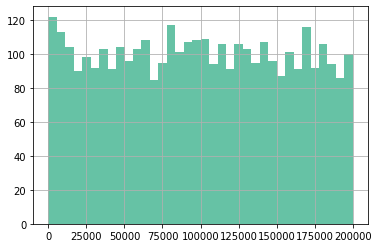

In [8]:
bank[bank['balance'].isnull() == True]['estimated_salary'].hist(bins=36)
plt.show()

Выведем максимальное значение по столбцу `estimated_salary`:

In [9]:
bank['estimated_salary'].max()

199992.48

По гистограмме видно, что зарплаты клиентов с пропущенными значениями в столбце `balance` весьма разнообразны, и не имеют тяготения к какому-то одному значению или интервалу значений. Обратимся к столбцу признака наличия кредитной карты и посмотрим, как много клиентов её имеют:

In [10]:
bank[bank['balance'].isnull() == True]['creditcard'].value_counts()

1    2592
0    1025
Name: creditcard, dtype: int64

Около 70% клиентов имеют кредитную карту, процент тот же, как и в целом по выборке. Посмотрим, каков процент активных клиентов в строках с пропусками:

In [11]:
bank[bank['balance'].isnull() == True]['loyalty'].value_counts()

1    1873
0    1744
Name: loyalty, dtype: int64

Активных и неактивных клиентов примерно поровну - этот показатель также сравним с показателем по всему датафрейму. Посмотрим на данные в разрезе города:

In [12]:
bank[bank['balance'].isnull() == True]['city'].value_counts()

Ярославль    2418
Рыбинск      1199
Name: city, dtype: int64

Клиенты с пропущенными значениями `balance` проживают только в Ярославле и Рыбинске. В Ростове Великом таких клиентов нет. Выведем на печать результаты по оставшимся полям.

In [13]:
bank[bank['balance'].isnull() == True]['gender'].value_counts()

М    1963
Ж    1654
Name: gender, dtype: int64

In [14]:
bank[bank['balance'].isnull() == True]['objects'].value_counts()

7     386
2     382
5     374
4     369
6     367
8     363
9     360
3     352
1     349
10    178
0     137
Name: objects, dtype: int64

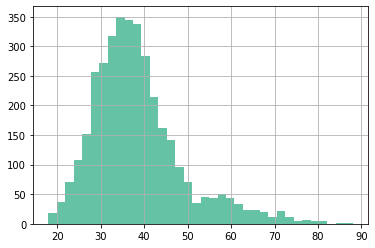

In [15]:
bank[bank['balance'].isnull() == True]['age'].hist(bins=36)
plt.show()

Видим, что аномалий в других признаках у клиентов с пропусками в поле остатка по счёту не наблюдается. Выведем на экран числовое описание признаков таких клиентов и сравним его с числовым описанием признаков по всей выборке.

In [16]:
bank[bank['balance'].isnull() == True][['score', 'age', 'objects',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn']].describe().T

,count,mean,std,min,25%,50%,75%,max
score,3617.000,649.453,96.159,350.000,583.000,651.000,717.000,850.000
age,3617.000,38.435,10.492,18.000,31.000,37.000,43.000,88.000
objects,3617.000,5.071,2.861,0.000,3.000,5.000,7.000,10.000
products,3617.000,1.785,0.496,1.000,1.000,2.000,2.000,4.000
creditcard,3617.000,0.717,0.451,0.000,0.000,1.000,1.000,1.000
loyalty,3617.000,0.518,0.500,0.000,0.000,1.000,1.000,1.000
estimated_salary,3617.000,98983.560,57730.829,90.070,49506.820,98618.790,148330.970,199992.480
churn,3617.000,0.138,0.345,0.000,0.000,0.000,0.000,1.000


Почти все показатели по выборке с пропусками очень близки к показателям по общей выборке. Только параметр оттока в выборке с пропусками заметно ниже. И выше мы увидели, что пропусков в поле `balance` не имеют клиенты из Ростова Великого. Эти результаты позволяют предположить, что пропуски в столбце `balance` скорее всего возникли из-за того, что у пользователь нет счёта или дебитовой карты в банке. Возможно, такие клиенты просто пользуются другими банковскими услугами, не открывая счёт (например, кредиты, аренда ячейки и т.д.), либо клиент мог закрыть существующую карту, и значение из поля баланса было удалено. Это даёт нам право заполнить пропуски нулями. Но прежде посмотрим, есть ли клиенты с нулевым остатком по счёту.

In [17]:
print('Количество клиентов с нулевым остатком по счёту:', bank[bank['balance'] == 0]['balance'].count())

Количество клиентов с нулевым остатком по счёту: 0


Клиентов с открытым счётом, на котором баланс 0, нет. Поэтому можем заменить все пропущенные значения на 0.

In [18]:
bank['balance'] = bank['balance'].fillna(0)

Проверим, все ли пропуски обработаны:

In [19]:
bank.isnull().sum()

userid              0
score               0
city                0
gender              0
age                 0
objects             0
balance             0
products            0
creditcard          0
loyalty             0
estimated_salary    0
churn               0
dtype: int64

Видим, что пропусков не осталось.

### Проверка на дубликаты

Проверим данные на наличие дубликатов:

In [20]:
print('Количество дубликатов в датафрейме:', bank.duplicated().sum())

Количество дубликатов в датафрейме: 0


**Вывод**

Приведя названия столбцов к нижнему регистру, обработав пропуски и проверив датафрейм на дубликаты, мы подготовили данные для дальнейшего исследования и работы.

## Исследовательский анализ данных

Вывод числового описания столбцов:

In [21]:
bank[['score', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn']].describe().T

,count,mean,std,min,25%,50%,75%,max
score,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
objects,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
balance,10000.000,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
products,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
creditcard,10000.000,0.706,0.456,0.000,0.000,1.000,1.000,1.000
loyalty,10000.000,0.515,0.500,0.000,0.000,1.000,1.000,1.000
estimated_salary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480
churn,10000.000,0.204,0.403,0.000,0.000,0.000,0.000,1.000


Из числового описания столбцов можно сделать следующие выводы:
- в столбцах кредитного рейтинга `score`, количества объектов в собственности `objects`, возраста `age` и зарплаты `estimated_salary` средние значения почти равны медианным, что даёт возможность предположить об отсутствии выбросов или об их малом количестве, слабо влияющем на общую картину;
- среднее значение поля остатка по счёту `balance` меньше медианного, значит, в выборке присутствует заметное количество выбросов на малых значениях (скорее всего, это влияние нулей, которыми мы заполнили пропуски в предыдущем шаге);
- среднее количество продуктов, которыми пользуется клиент `products` равно 1.53, это говорит о том, что большинство клиентов пользуются одним или двумя продуктами. Эту гипотезу подтверждают величины второго и третьего кваритиля;
- второй квартиль столбца-признака активного клиента `loyalty` равен 0, а третий - 1, а среднее значение 0.52, следовательно, в выборке активных и неактивных пользователей банка примерно попровну;
- из показателей столбца `creditcard` можно сделать вывод, что кредитные карты есть у 70% клиентов, а из показателей `churn` - что в отток ушло всего около 20% клиентов.

Построим распределения:

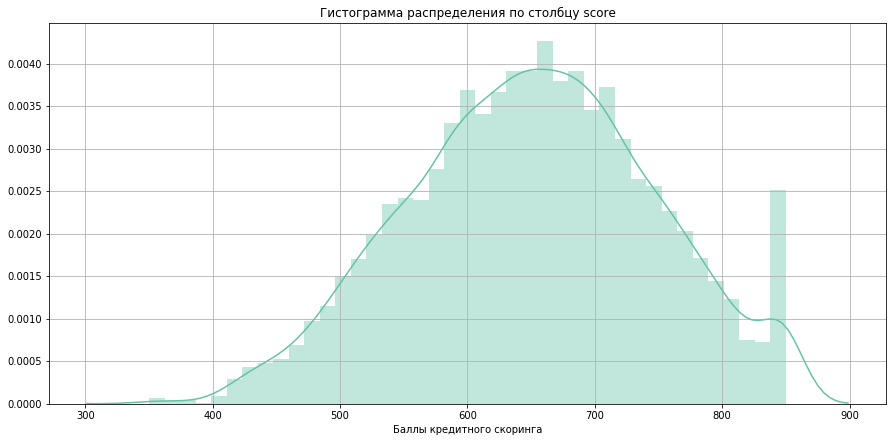

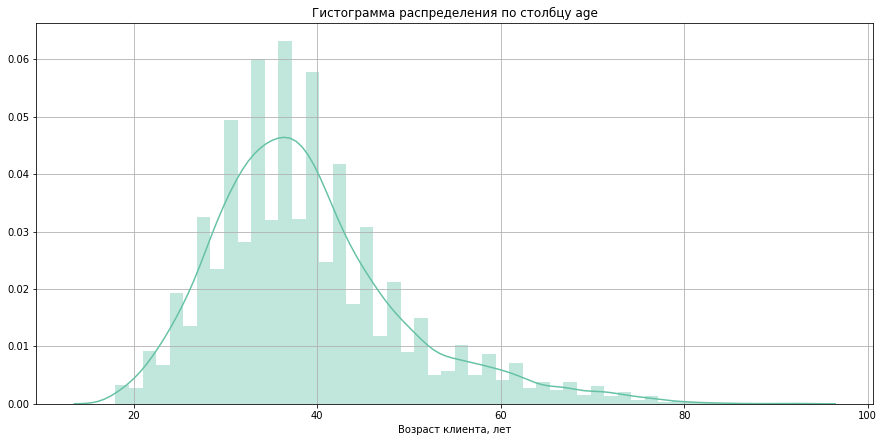

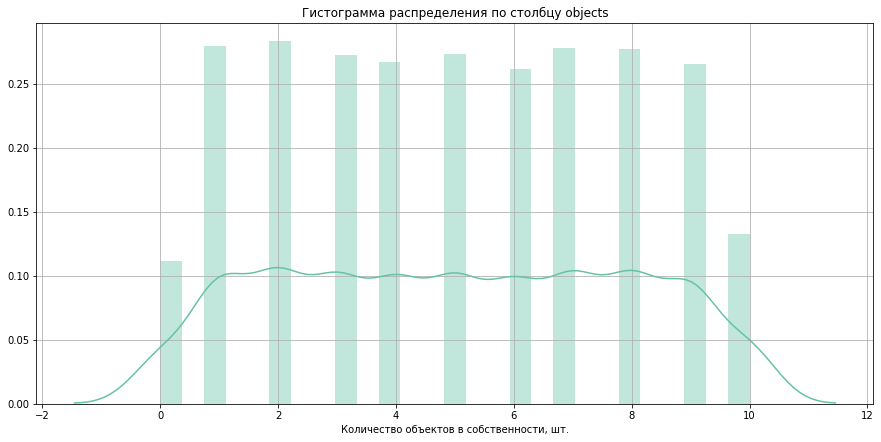

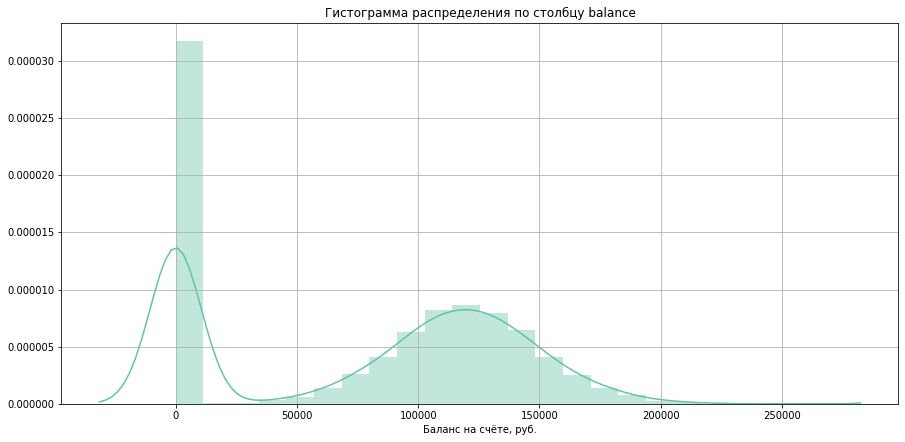

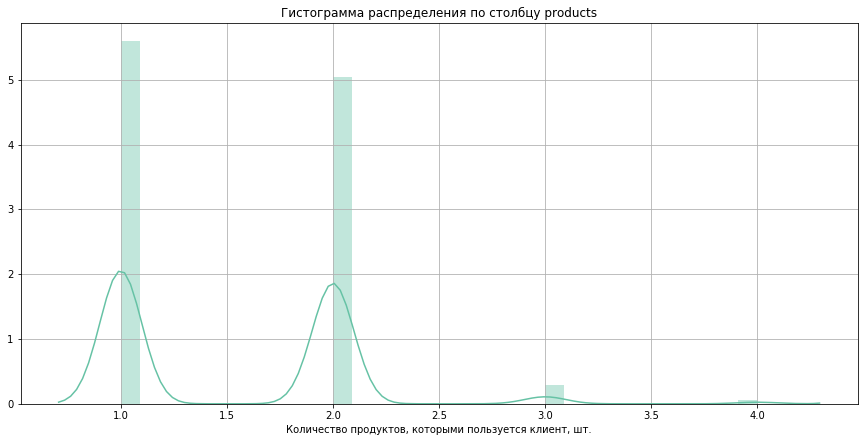

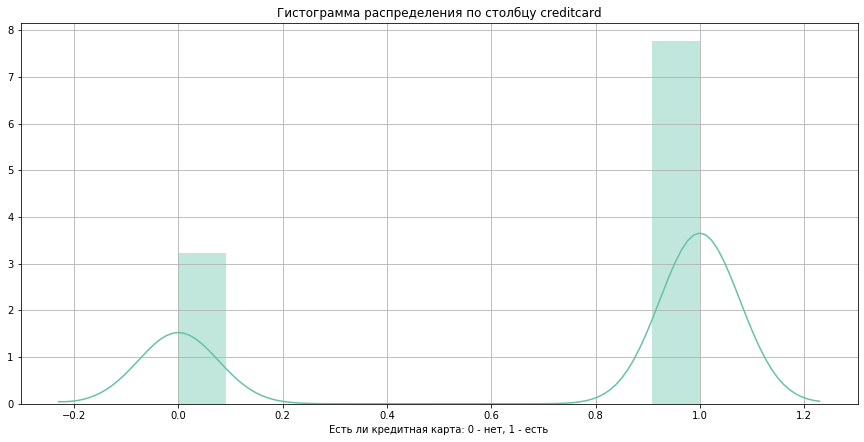

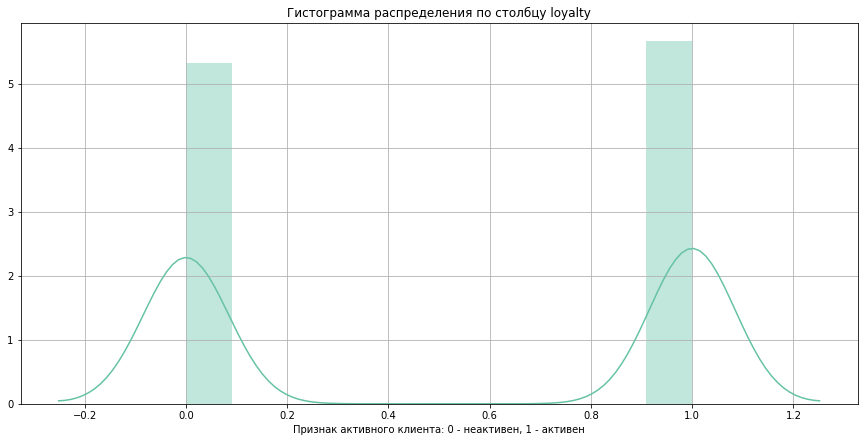

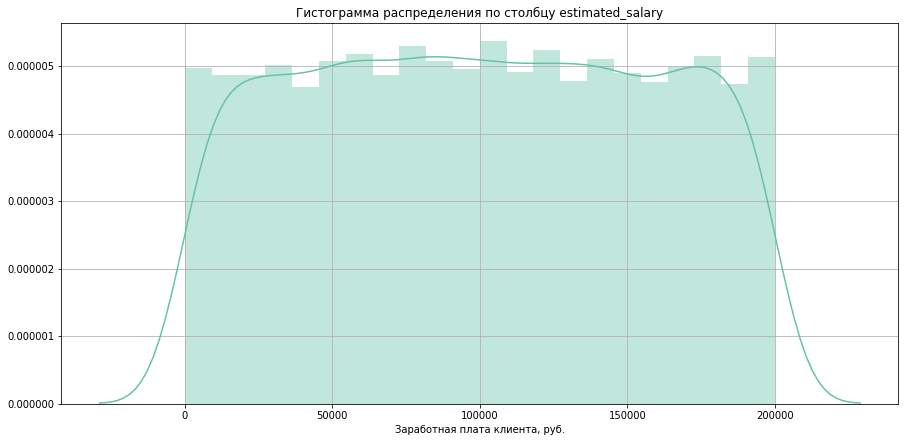

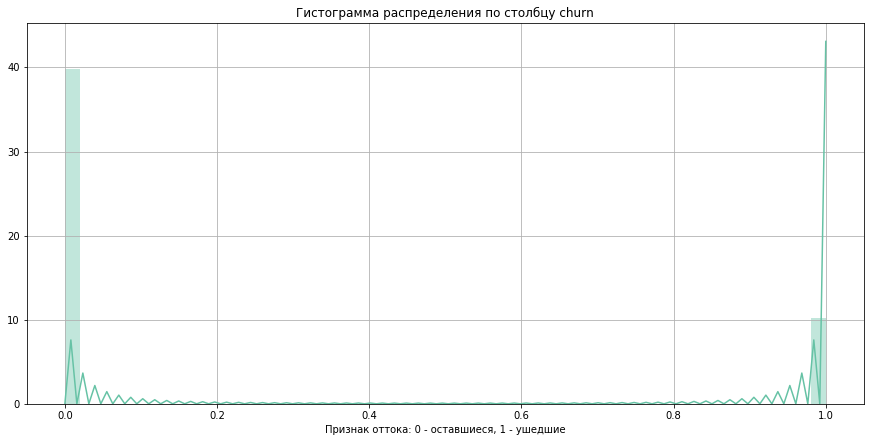

In [22]:
dict_of_col = {'score': 'Баллы кредитного скоринга',
               'age': 'Возраст клиента, лет',
               'objects': 'Количество объектов в собственности, шт.',
               'balance': 'Баланс на счёте, руб.',
               'products': 'Количество продуктов, которыми пользуется клиент, шт.',
               'creditcard': 'Есть ли кредитная карта: 0 - нет, 1 - есть',
               'loyalty': 'Признак активного клиента: 0 - неактивен, 1 - активен',
               'estimated_salary': 'Заработная плата клиента, руб.',
               'churn': 'Признак оттока: 0 - оставшиеся, 1 - ушедшие'
               }

for col in dict_of_col.keys():
    plt.figure(figsize=(15, 7))
    ax = sns.distplot(bank[col])
    ax.set_title('Гистограмма распределения по столбцу ' + col)
    ax.set_xlabel(dict_of_col[col])
    plt.grid()
    plt.show()

В целом гистрограммы подтвердили те предположения, которые были сформулированы в ходе анализа числового описания столбцов. Однако здесь нужно выделить несколько интересных наблюдений:
- виден пик на значении максимального кредитного рейтинга;
- число клиентов с количеством объектов в собственности от 1 до 9 включительно примерно одинаково. Тех, у кого нет объектов, и тех, у кого их 10, заметно меньше;
- отчетливо видны выбросы у нуля по столбцу `balance`;
- людей с разным уровнем заработной платы в выборке примерно поровну.

Посмотрим, как распределены пользователи по полу и по разным городам:

In [23]:
(bank
 .groupby('gender')
 .agg({'userid': 'nunique'})
 .reset_index()
 .rename(columns={'gender': 'Пол', 'userid': 'Количество'})
)

,Пол,Количество
0,Ж,4543
1,М,5457


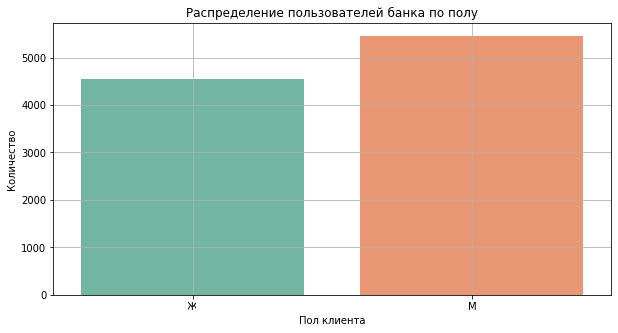

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='gender', y='userid', data=bank.groupby('gender').agg({'userid': 'nunique'}).reset_index())
ax.set_title('Распределение пользователей банка по полу')
ax.set_xlabel('Пол клиента')
ax.set_ylabel('Количество')
plt.grid()
plt.show()

В выборке мужчин больше, чем женщин на 16%.

In [25]:
(bank
 .groupby('city')
 .agg({'userid': 'nunique'})
 .reset_index()
 .rename(columns={'city': 'Город', 'userid': 'Количество'})
)

,Город,Количество
0,Ростов Великий,2509
1,Рыбинск,2477
2,Ярославль,5014


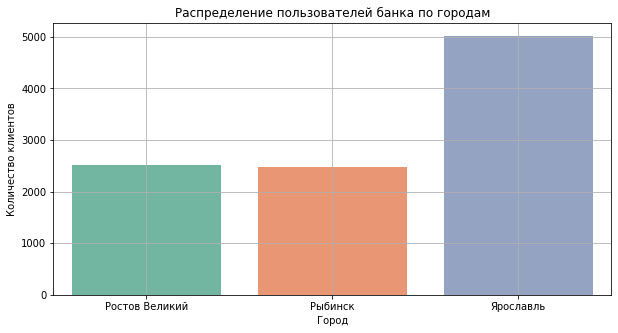

In [26]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='city', y='userid', data=bank.groupby('city').agg({'userid': 'nunique'}).reset_index())
ax.set_title('Распределение пользователей банка по городам')
ax.set_xlabel('Город')
ax.set_ylabel('Количество клиентов')
plt.grid()
plt.show()

Больше всего среди клиентов банка жителей Ярославля. Жителей Ростова Великого и Рыбинска примерно поровну, и количество жителей каждого из них в отдельности приблизительно в 2 раза меньше, чем Ярославля.

Для полноты картины построим диаграммы размаха для всех признаков:

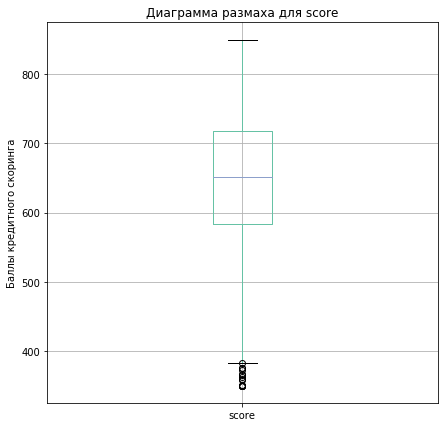

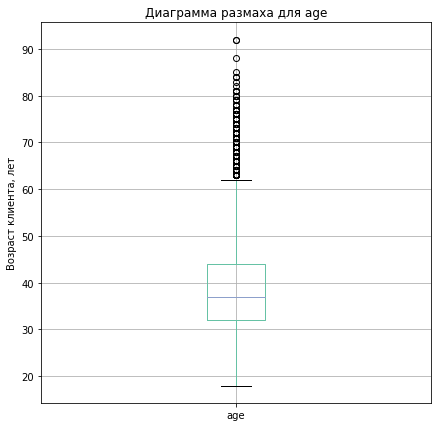

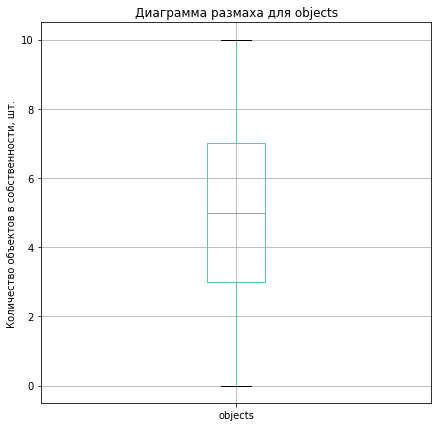

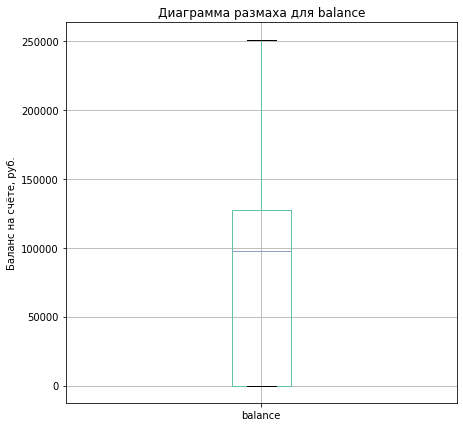

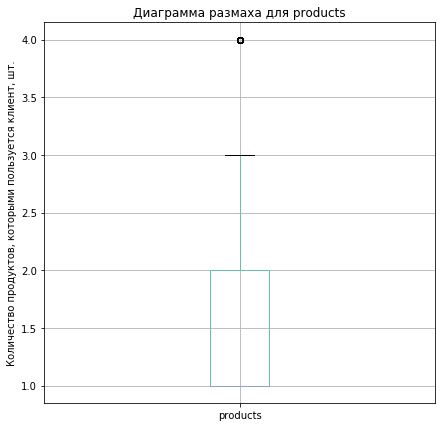

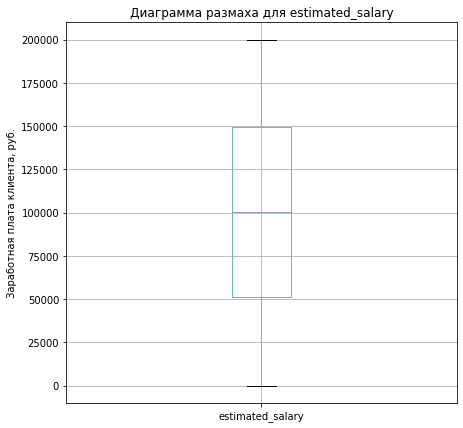

In [27]:
dict_of_col = {'score': 'Баллы кредитного скоринга',
               'age': 'Возраст клиента, лет',
               'objects': 'Количество объектов в собственности, шт.',
               'balance': 'Баланс на счёте, руб.',
               'products': 'Количество продуктов, которыми пользуется клиент, шт.',
               'estimated_salary': 'Заработная плата клиента, руб.',
               }

for col in dict_of_col.keys():
    plt.figure(figsize=(7, 7))
    ax = bank[[col]].boxplot()
    ax.set_title('Диаграмма размаха для ' + col)
    ax.set_ylabel(dict_of_col[col])
    plt.show()

Выбросы значений по баллам кредитного скоринга лежат на малых значениях, меньших 400. Большинству клиентов банка до 62 лет, клиенты старше этого возраста встречаются намного реже. В выборке очень редки клиенты, которые пользуются 4 банковскими продуктами. По боксплоту для `objects` видно, что выбросов в значениях этого параметра нет, это же касается полей `estimated_salary` и `balance`. 

**Вывод**

В процессе исследовательского анализа данных были сделаны следующие выводы:
- Большинство клиентов пользуются одним или двумя продуктами;
- Мужчин в выборке на 16% больше, чем женщин;
- Наибольшее количество пользователей банка проживает в Ярославле, клиентов из Ростова Великого примерно в два раза меньше, чем из Ярославля, также как и клиентов из Рыбинска;
- Активных и неактивных клиентов примерно поровну в выборке;
- В столбце `balance` есть выбросы на значении `0` - эти значения соответствуют клиентам, у которых нет счёта;
- Кредитными картами пользуются около 70% клиентов;
- В отток ушло примерно 20% клиентов.

## Сегментирование и составление портретов пользователей

Проанализируем зависимости между количеством продуктов, которыми пользуется клиент, и каждым из параметров: возраст, баллы кредитного скоринга, количество объектов в собственности, баланс, есть ли кредитная карта, признак активности, заработная плата и отток. Построим графики и посчитаем средние параметры по клиентам с разным числом банковских продуктов.

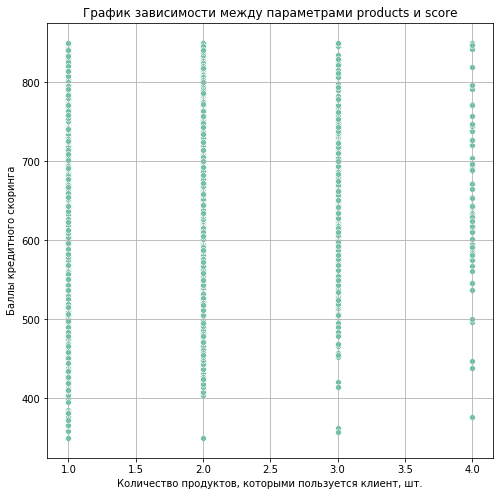

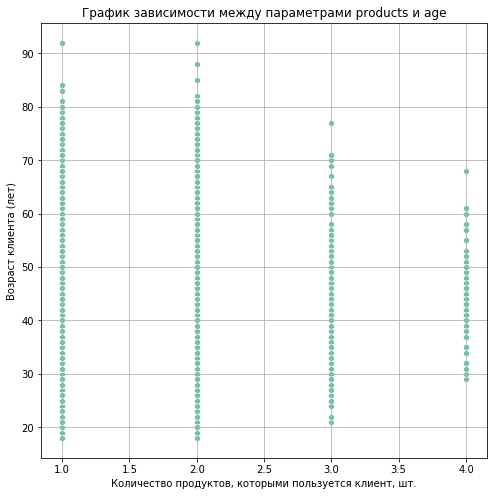

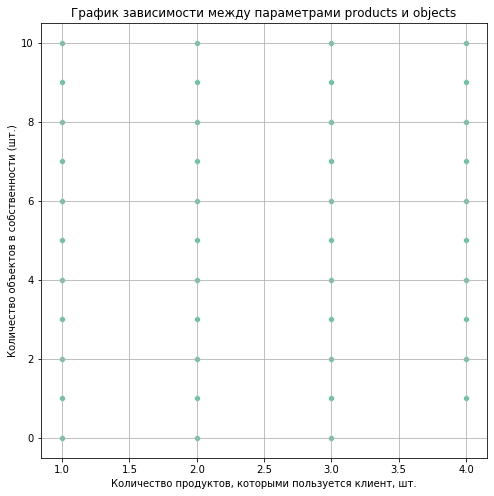

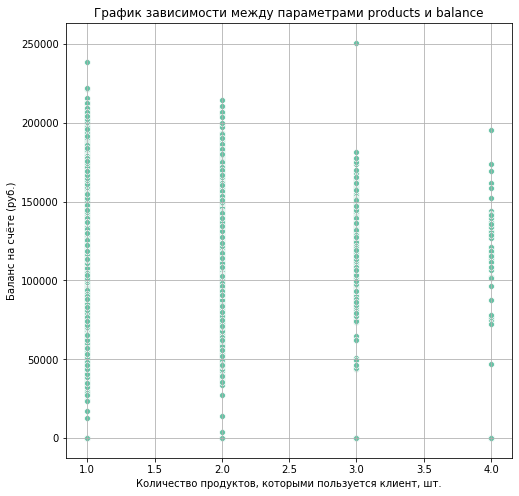

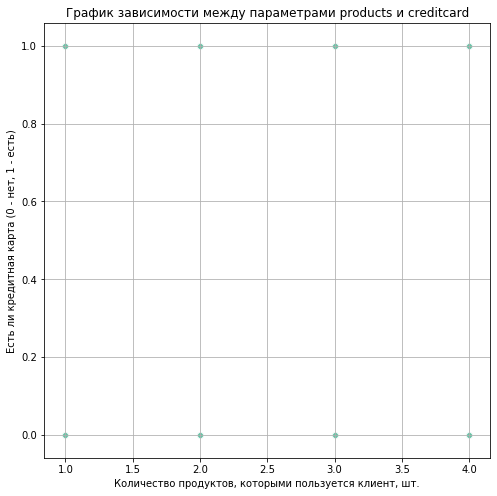

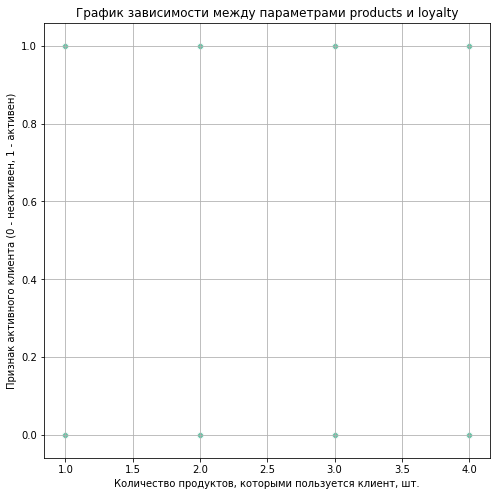

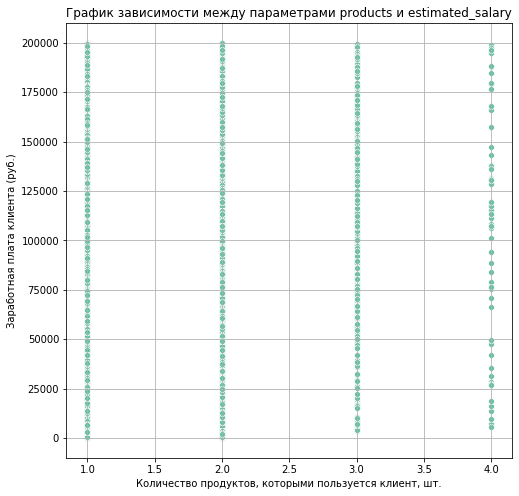

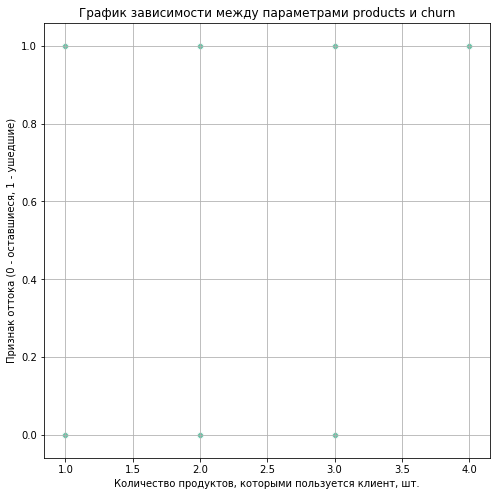

In [28]:
dict_of_col = {'score': 'Баллы кредитного скоринга',
               'age': 'Возраст клиента (лет)',
               'objects': 'Количество объектов в собственности (шт.)',
               'balance': 'Баланс на счёте (руб.)',
               'creditcard': 'Есть ли кредитная карта (0 - нет, 1 - есть)',
               'loyalty': 'Признак активного клиента (0 - неактивен, 1 - активен)',
               'estimated_salary': 'Заработная плата клиента (руб.)',
               'churn': 'Признак оттока (0 - оставшиеся, 1 - ушедшие)'
               }

for col in dict_of_col.keys():
    plt.figure(figsize=(8, 8))
    ax = sns.scatterplot(data=bank, x="products", y=col)
    ax.set_title('График зависимости между параметрами products и ' + col)
    ax.set_xlabel('Количество продуктов, которыми пользуется клиент, шт.')
    ax.set_ylabel(dict_of_col[col])
    plt.grid()
    plt.show()

Выведем средние значения признаков для клиентов с разным количеством банковских продуктов: 

In [29]:
bank[['score', 'age', 'objects', 'balance',
       'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn']].groupby('products').mean().T

products,1,2,3,4
score,649.121,652.189,648.105,653.583
age,39.673,37.754,43.195,45.683
objects,4.975,5.052,5.004,5.300
balance,98551.871,51879.146,75458.328,93733.135
creditcard,0.704,0.707,0.714,0.683
loyalty,0.504,0.533,0.425,0.483
estimated_salary,99487.257,100452.013,104318.131,104763.723
churn,0.277,0.076,0.827,1.000


Из графиков, значений корреляции и выведенной информации видны следующие закономерности:
- клиенты с 1 и 2 продуктами моложе, чем клиенты с 3 и 4 продуктами;
- самый низкий кредитный рейтинг у клиентов с 3 продуктами, а самый высокий - у клиентов с 4 продуктами;
- клиенты с 1 и 2 продуктами активнее, чем клиенты с 3 и 4;
- клиенты с 3 и 4 продуктами имеют более высокую зарплату, но и оттекают намного чаще;
- самое большое количество объектов в собственности в среднем у клиентов с 4 продуктами;
- самый маленький остаток на счёте у клиентов с 2 продуктами, а самый высокий - у пользователей с 1 продуктом.

Как можно заметить, многие показатели у клиентов с 3 и 4 продуктами похожи. К тому же, клиентов с 1 и 2 продуктами примерно одинаковое количество, а клиентов с 3 и более продуктами значительно меньше. Поэтому сегментируем клиентов по количеству продуктов, которыми они пользуются: 1, 2 и 3 и более. Добавим новый столбец к датафрейму `products_category`.

In [30]:
def products_category_func(products):
    if products == 1:
        return '1'
    elif products == 2:
        return '2'
    else:
        return '3 и более'

# применим функцию к столбцу 'products' и сохраним результат в столбец 'products_category'
bank['products_category'] = bank['products'].apply(products_category_func)

# проверим результат вызовом метода .value_counts()
bank['products_category'].value_counts().reset_index()

,index,products_category
0,1,5084
1,2,4590
2,3 и более,326


Построим диаграммы распределения клиентов по сегментам:

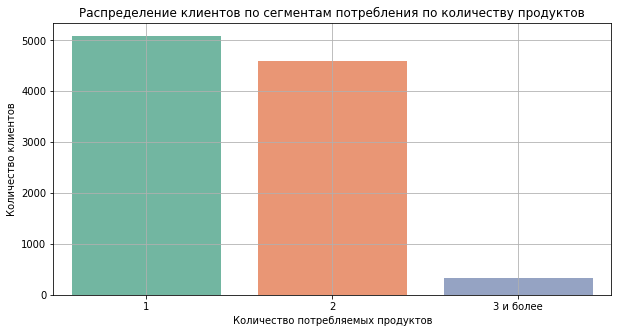

In [31]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='index', y='products_category', data=bank['products_category'].value_counts().reset_index())
ax.set_title('Распределение клиентов по сегментам потребления по количеству продуктов')
ax.set_xlabel('Количество потребляемых продуктов')
ax.set_ylabel('Количество клиентов')
plt.grid()
plt.show()

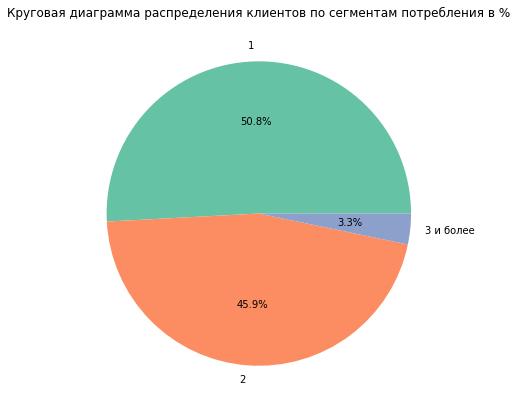

In [32]:
values = bank['products_category'].value_counts().reset_index()['products_category']
labels = bank['products_category'].value_counts().reset_index()['index']
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(values, labels=labels, autopct='%1.1f%%')
plt.title('Круговая диаграмма распределения клиентов по сегментам потребления в %')
plt.show()

Посмотрим, как распределены признаки внутри каждой из получившихся категорий. Для этого построим графики. Для непрерывных величин построим гистограммы, а для дискретных - countplot-ы:

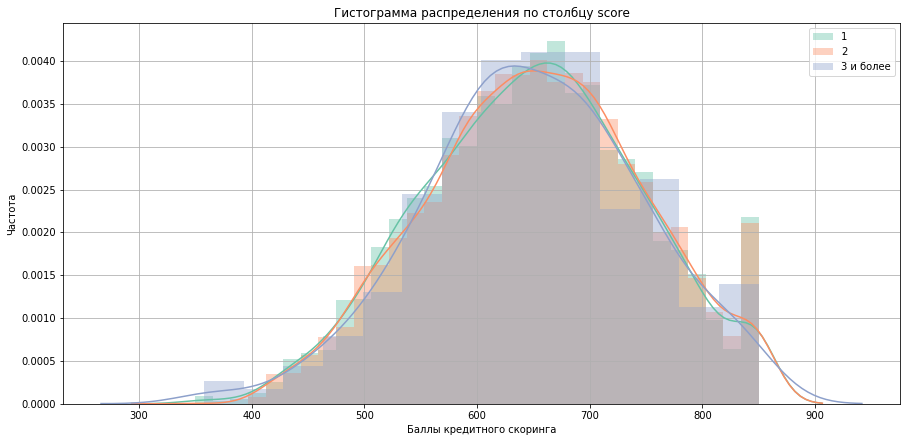

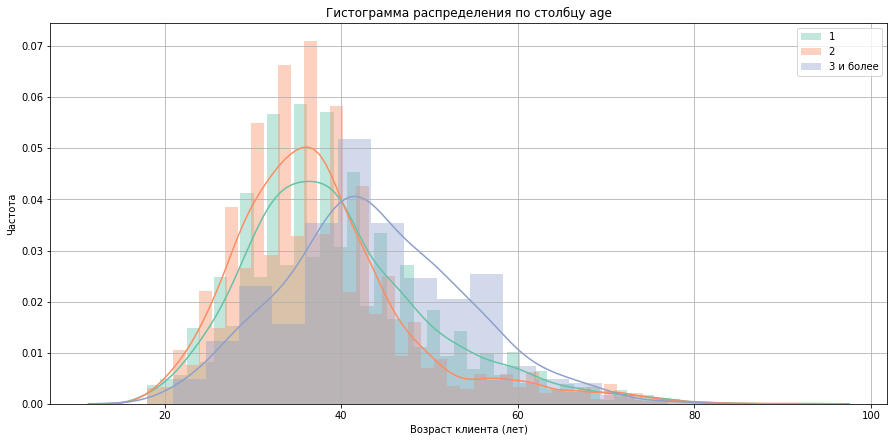

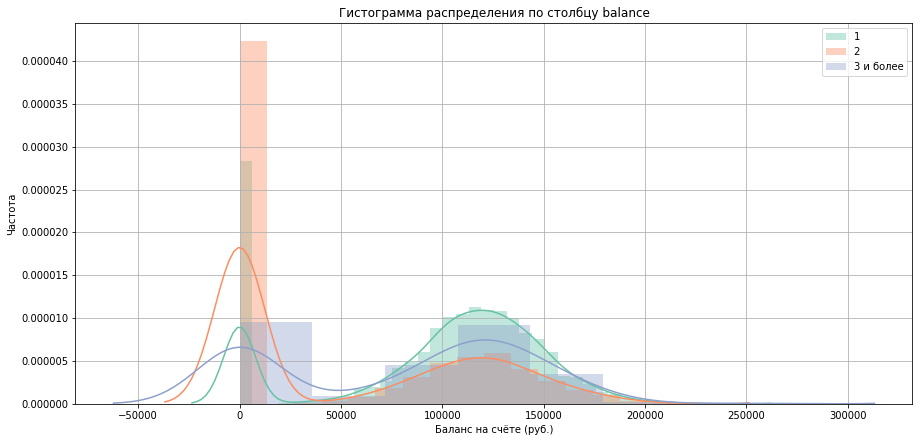

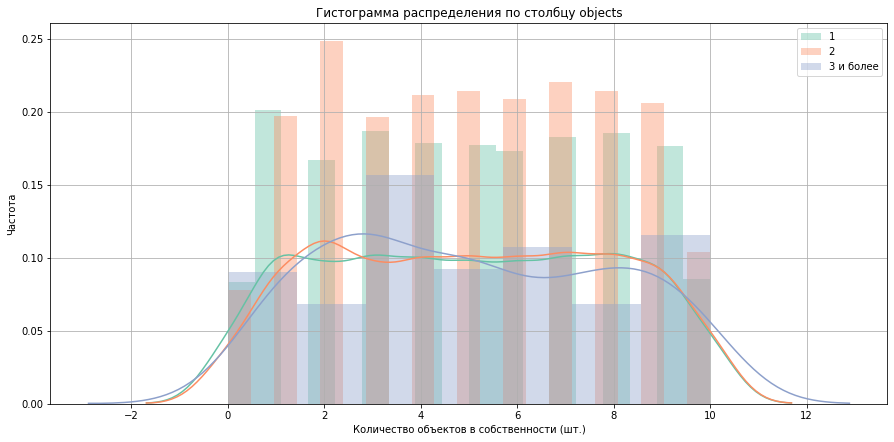

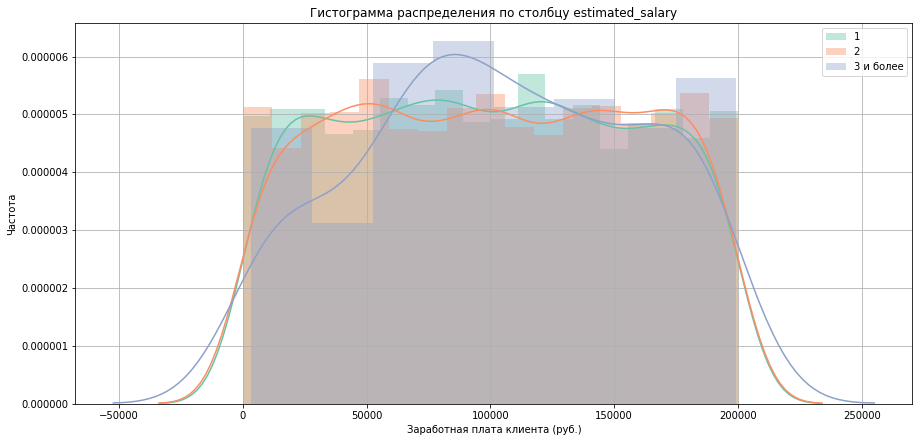

In [33]:
dict_of_col = {'score': 'Баллы кредитного скоринга',
               'age': 'Возраст клиента (лет)',
               'balance': 'Баланс на счёте (руб.)',
               'objects': 'Количество объектов в собственности (шт.)',
               'estimated_salary': 'Заработная плата клиента (руб.)'
               }

for col in dict_of_col.keys():
    plt.figure(figsize=(15, 7))
    ax1 = sns.distplot(bank[bank['products_category'] == '1'][col], label='1')
    ax2 = sns.distplot(bank[bank['products_category'] == '2'][col], label='2')
    ax3 = sns.distplot(bank[bank['products_category'] == '3 и более'][col], label='3 и более')
    ax1.set_title('Гистограмма распределения по столбцу ' + col)
    ax1.set_xlabel(dict_of_col[col])
    ax1.set_ylabel('Частота')
    ax1.legend(loc = 'upper right')
    ax2.legend(loc = 'upper right')
    ax3.legend(loc = 'upper right')
    plt.grid()
    plt.show()

Распределение баллов кредитного скоринга и количества объектов в собственности по разным категориям практически одинаковое. Распределение по возрасту подтверждает сделанный ранее вывод, что клиенты, пользующиеся 3 и более продуктами, старше других. Гистограмма по балансу на счёте показывает, что меньше всего денег у клиентов с 2 продуктами, а больше всего - у клиентов с одним продуктом. По гистограмме зарплаты видно, что у клиентов с 1 и 2 продуктами уровень зарплаты примерно одинаков, а у клиентов в 3 и более продуктами он выше.

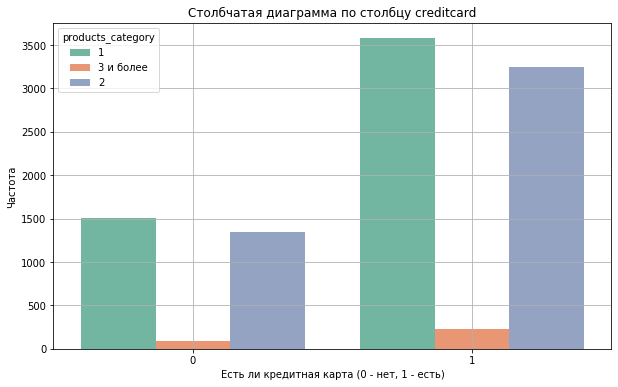

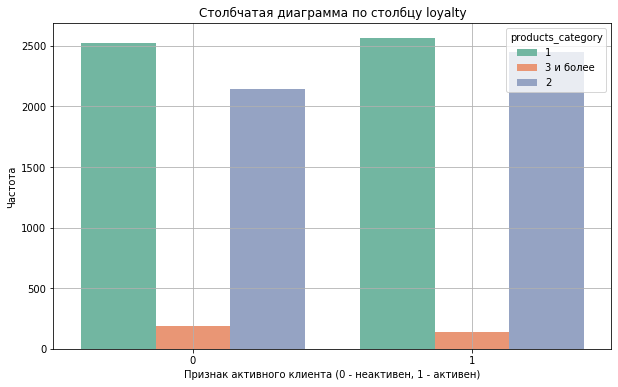

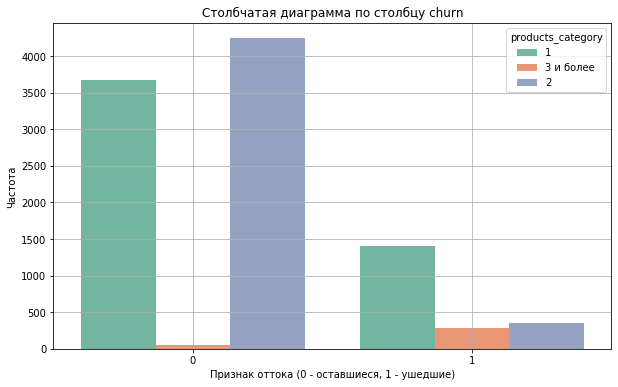

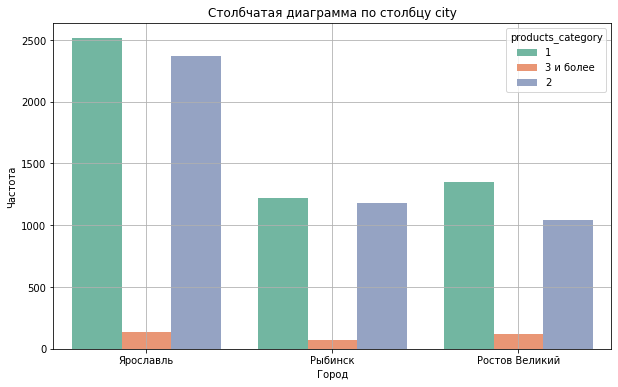

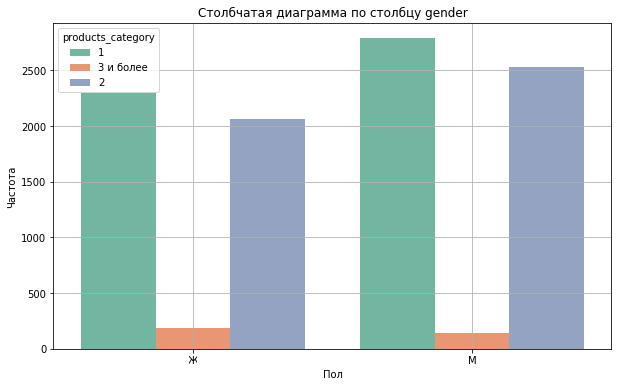

In [34]:
dict_of_col_d = {'creditcard': 'Есть ли кредитная карта (0 - нет, 1 - есть)',
                 'loyalty': 'Признак активного клиента (0 - неактивен, 1 - активен)',
                 'churn': 'Признак оттока (0 - оставшиеся, 1 - ушедшие)',
                 'city': 'Город',
                 'gender': 'Пол'
                }

for col in dict_of_col_d.keys():
    plt.figure(figsize=(10, 6))
    sns.countplot(x = bank[col], hue='products_category', data=bank)
    plt.title('Столбчатая диаграмма по столбцу ' + col)
    plt.xlabel(dict_of_col_d[col])
    plt.ylabel('Частота')
    plt.grid()
    plt.show()

Распределение клиентов по категориям в группах клиентов, имеющих кредитную карту, и не имеющих её, практически одинаково. Активных и неактивных клиентов с одним банковским продуктом примерно поровну, тогда как в категории клиентов, имеющих 2 продукта, количество активных заметно больше, а в категории "3 и более" наоборот, больше неактивных. Клиенты с 2 продуктами оттекают очень слабо, клиенты с одним продуктом оттекают интенсивнее. Самый большой процент оттока наблюдается среди клиентов с 3 и более продуктами. Самое маленькое количество клиентов с 3 и более продуктами живёт в Рыбинске, однако визуально видно, что их процентное соотношение с другими категориями очень похоже на картину распределения клиентов по категориям в Ярославле. В Ростове Великом немного другая картина - там клиентов, имеющих 3 и более продуктов, по абсолютному значению плюс-минус столько же, сколько и в Ярославле, при том что в Ярославле проживает в 2 раза больше клиентов, чем в Ростове Великом. Распределение по полу показывает, что женщин с 3 и более продуктами больше, чем мужчин, в то время как в выборке мужчин больше, чем женщин.

Выведем на экран таблицу со средними и медианными значениями параметров по каждой категории:

In [35]:
print('Средние значения параметров по категориям')
bank[['score', 'age', 'objects', 'balance',
       'products_category', 'creditcard', 'loyalty', 'estimated_salary', 'churn']].groupby('products_category').mean().T

Средние значения параметров по категориям


products_category,1,2,3 и более
score,649.121,652.189,649.113
age,39.673,37.754,43.653
objects,4.975,5.052,5.058
balance,98551.871,51879.146,78821.790
creditcard,0.704,0.707,0.709
loyalty,0.504,0.533,0.436
estimated_salary,99487.257,100452.013,104400.142
churn,0.277,0.076,0.859


In [36]:
print('Медианные значения параметров по категориям')
bank[['score', 'age', 'objects', 'balance',
       'products_category', 'creditcard', 'loyalty', 'estimated_salary', 'churn']].groupby('products_category').median().T

Медианные значения параметров по категориям


products_category,1,2,3 и более
score,651.000,653.000,650.000
age,38.000,36.000,43.000
objects,5.000,5.000,5.000
balance,111886.035,0.000,101628.675
creditcard,1.000,1.000,1.000
loyalty,1.000,1.000,0.000
estimated_salary,99226.830,100738.855,103874.670
churn,0.000,0.000,1.000


**Вывод**

Сегментировав клиентов по количеству используемых банковских продукта на три категории (1, 2, 3 и более), мы получили возможность описать портреты клиентов из каждой категории.

Клиенты с 1 банковским продуктом: 
- имеют кредитный рейтинг в среднем 649 из 850;
- большая часть из них проживает в Ярославле, затем идёт Ростов Великий, и на последнем месте по численности Рыбинск;
- мужчин среди них больше, чем женщин;
- их средний возраст 39 лет;
- они имеют в среднем 5 объектов в собственности;
- имеют в среднем самые высокие остатки по счету по сравнению с клиентами из других категорий;
- 70% из них используют кредитную карту;
- половина из них является активными клиентами;
- их средняя зарплата составляет примерно 99 000 руб;
- оттекают со средней интенсивностью (процент оттока равен 27.7).

Клиенты с 2 банковскими продуками:
- имеют кредитный рейтинг в среднем 652 из 850;
- большая часть из них проживает в Ярославле, затем идёт Рыбинск, затем - Ростов Великий;
- мужчин больше, чем женщин;
- их средний возраст 37 лет;
- имеют в среднем 5 объектов в собственности;
- имеют в среднем самые низкие остатки по счету по сравнению с клиентами из других категорий. Около половины клиентов не имеют счёта (в данных отображается остаток 0);
- 70% из них используют кредитную карту;
- чуть больше половины из них - активные клиенты;
- средняя зарплата равна примерно 100 000 руб;
- наименее склонны к оттоку (всего 7.6% ушедших).

Клиенты с 3 и более банковскими продуками:
- имеют кредитный рейтинг в среднем 649 из 850;
- в Ярославле и Ростове Великом проживает почти одинаковое количество клиентов, в Рыбинске проживает в 2 раза меньше, чем в Ярославле;
- женщин больше, чем мужчин;
- средний возраст - 43 года;
- имеют в среднем 5 объектов в собственности;
- 70% пользуются кредитной картой;
- из них активных пользователей менее половины;
- средняя зарплата самая высокая, чем у клиентов из других категорий, и составляет 104 000 руб.;
- оттекают с высокой интенсивностью (85.9% ушли).

## Проверка гипотез

Начнём с подсчёта дисперсий по зарплате двух выборок - клиентов с одним банковским продуктом и клиентов с двумя банковскими продуктами. Так как мы имеем дело не с генеральной совокупностью всех клиентов, а с выборкой, то при расчёте дисперсии добавим в метод `.var()` параметр `ddof=1`.

In [37]:
print('Дисперсия по столбцу estimated_salary для клиентов с одним банковским продуктом:', 
      np.var(bank[bank['products_category'] == '1']['estimated_salary'], ddof=1))

print('Дисперсия по столбцу estimated_salary для клиентов с двумя банковскими продуктами:', 
      np.var(bank[bank['products_category'] == '2']['estimated_salary'], ddof=1))

Дисперсия по столбцу estimated_salary для клиентов с одним банковским продуктом: 3290585635.088143
Дисперсия по столбцу estimated_salary для клиентов с двумя банковскими продуктами: 3339776562.810999


Построим распределения дохода клиентов с одним и двумя продуктами:

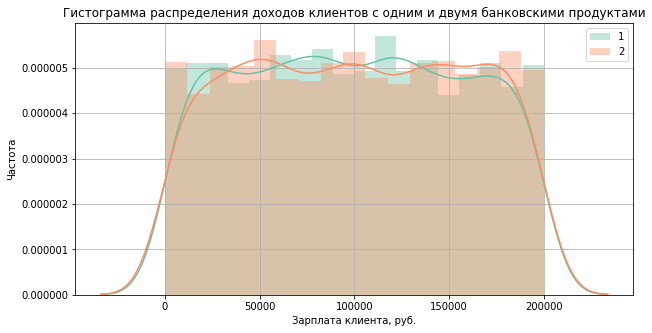

In [38]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(bank[bank['products_category'] == '1']['estimated_salary'], label='1')
ax2 = sns.distplot(bank[bank['products_category'] == '2']['estimated_salary'], label='2')
ax1.set_title('Гистограмма распределения доходов клиентов с одним и двумя банковскими продуктами')
ax1.set_xlabel('Зарплата клиента, руб.')
ax1.set_ylabel('Частота')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.grid()
plt.show()

Проверим гипотезу различия дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним. Начнём с формулировки нулевой гипотезы. Поскольку нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства, то в нашем случае она будет звучать так:

*Средний доход клиентов с одним продуктом банка и средний доход клиентов с двумя продуктами не отличаются*

Альтернативную гипотезу для такой нулевой гипотезы сформулируем как:

*Средний доход клиентов с одним продуктом банка и средний доход клиентов с двумя продуктами различается*

Так как мы проверяем равенство средних двух независимых генеральных совокупностей по их выборкам, то для проверки гипотезы используем метод `.ttest_ind()` из библиотеки `scipy`, применив его к столбцу `estimated_salary`. Из предыдущего шага мы увидели, что дисперсии по выручке обеих выборок близки по значению, а размеры выборок отличаются не более чем на 10%, поэтому параметр `equal_var` при вызове метода указывать не будем (тогда он примет значение по умолчанию - True). Установим критический уровень статистической значимости 5%. 

In [39]:
alpha = 0.05  # критический уровень статистической значимости

results = st.ttest_ind(
    bank[bank['products_category'] == '1']['estimated_salary'],
    bank[bank['products_category'] == '2']['estimated_salary'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.41047183624949335
Не получилось отвергнуть нулевую гипотезу


Видим, что pvalue получился значительно больше 5%, поэтому нулевую гипотезу не отвергаем. То есть средний доход клиентов с одним продуктом банка и средний доход клиентов с двумя продуктами не различается.<br><br>

Проверим гипотезу разности остатков по счетам для клиентов из Ярославля и клиентов из других городов.

Нулевая гипотеза: *Средние остатки по счетам клиентов из Ярославля и клиентов из других городов не отличаются*

Альтернативная гипотеза: *Средние остатки по счетам клиентов из Ярославля и клиентов из других городов различаются*

Сначала посчитаем дисперсию, размеры выборок и построим распределения:

In [40]:
print('Дисперсия по столбцу balance для клиентов из Ярославля:', 
      np.var(bank[bank['city'] == 'Ярославль']['balance'], ddof=1))

print('Дисперсия по столбцу balance для клиентов не из Ярославля:', 
      np.var(bank[bank['city'] != 'Ярославль']['balance'], ddof=1))

Дисперсия по столбцу balance для клиентов из Ярославля: 4113114226.8820925
Дисперсия по столбцу balance для клиентов не из Ярославля: 3255393298.956616


In [41]:
print('Количество клиентов из Ярославля:', 
      bank[bank['city'] == 'Ярославль']['userid'].count())

print('Количество клиентов из других городов::', 
      bank[bank['city'] != 'Ярославль']['userid'].count())

Количество клиентов из Ярославля: 5014
Количество клиентов из других городов:: 4986


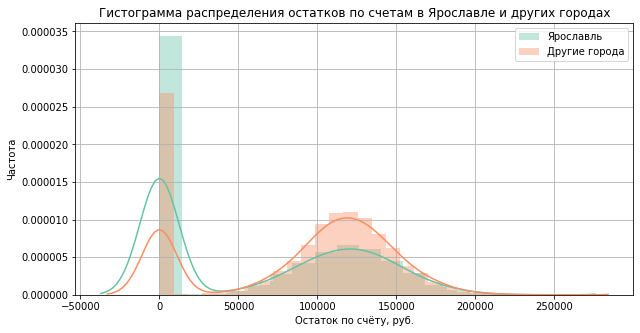

In [42]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(bank[bank['city'] == 'Ярославль']['balance'], label='Ярославль')
ax2 = sns.distplot(bank[bank['city'] != 'Ярославль']['balance'], label='Другие города')
ax1.set_title('Гистограмма распределения остатков по счетам в Ярославле и других городах')
ax1.set_xlabel('Остаток по счёту, руб.')
ax1.set_ylabel('Частота')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.grid()
plt.show()

Размеры выборок примерно одинаковы, но дисперсии отличаются, поэтому передадим в метод `equal_var = False`:

In [43]:
results = st.ttest_ind(
    bank[bank['city'] == 'Ярославль']['balance'],
    bank[bank['city'] != 'Ярославль']['balance'],
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 1.2523498173777572e-121
Отвергаем нулевую гипотезу


Видим, что pvalue получился очень близким к нулю, и мы отвергаем нулевую гипотезу. Значит, мы не отвергаем альтернативную гипотезу о том, что средние остатки по счетам клиентов из Ярославля и клиентов из других городов различаются.

Проверим эту же гипотезу, но исключив из выборки выбросы на значении 0 в поле баланса. Также построим распределения.

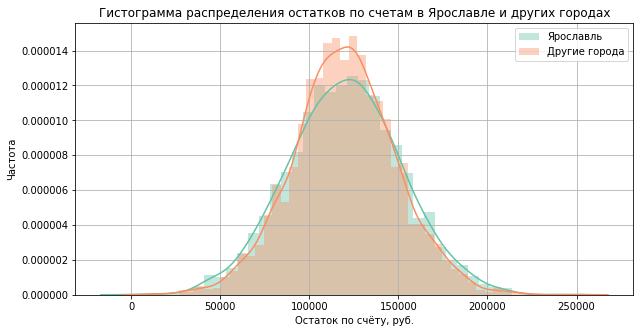

In [44]:
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(bank[(bank['city'] == 'Ярославль') & (bank['balance'] != 0)]['balance'], label='Ярославль')
ax2 = sns.distplot(bank[(bank['city'] != 'Ярославль') & (bank['balance'] != 0)]['balance'], label='Другие города')
ax1.set_title('Гистограмма распределения остатков по счетам в Ярославле и других городах')
ax1.set_xlabel('Остаток по счёту, руб.')
ax1.set_ylabel('Частота')
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
plt.grid()
plt.show()

In [45]:
results = st.ttest_ind(
    bank[(bank['city'] == 'Ярославль') & (bank['balance'] != 0)]['balance'],
    bank[(bank['city'] != 'Ярославль') & (bank['balance'] != 0)]['balance'],
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.8285222117901233
Не получилось отвергнуть нулевую гипотезу


Проверка гипотезы по выборке без выбросов показала противоположный результат, то есть средние значения остатков по счёту в Ярославле и в других городах без учёта клиентов, не имеющих дебетовой карты или счета, не различаются.

**Вывод**

Проверка показала, что средний доход клиентов с одним продуктом банка и средний доход клиентов с двумя продуктами не различается. Гипотеза о различии средних остатков по счёту проверялась в двух вариантах: с учётом клиентов, не имеющих дебетовой карты, и без учёта. Выяснилось, что если учитывать клиентов без остатков по счету, то средние значения остатков по двум выборкам различаются. А если таких клиентов не учитывать, то остатки по счетам клиентов из Ярославля и клиентов из других городов не различаются.

## Выводы и рекомендации

**Выводы**

В ходе исследовательского анализа мы выявили следующие закономерности: большинство клиентов пользуются одним или двумя продуктами; мужчин в выборке на 16% больше, чем женщин; активных и неактивных клиентов примерно поровну в выборке; кредитными картами пользуются около 70% клиентов; в отток ушло примерно 20% клиентов.

Далее мы сегментировали клиентов по количеству потребяемых продуктов и выделили 3 сегмента: клиенты, которые пользуются одним банковским продуктом, клиенты, которые пользуются двумя банковскими продуктами и клиенты, которые пользуются 3 и более банковскими продуктами. Проанализировав данные в разрезе сегментов, мы описали портреты пользователей каждого сегмента. Подробное описание портретов пользователей приведено в выводе к шагу 4.

Также мы проверили две гипотезы: гипотезу различия среднего дохода между теми клиентами, которые пользуются двумя продуктами банка, и теми, которые пользуются одним, и гипотезу различия средних остатков по счетам клиентов из Ярославля и клиентов из других городов. Проверка показала, что средний доход клиентов с одним продуктом банка и доход клиентов с двумя продуктами не различается. Гипотеза о различии средних остатков по счёту проверялась в двух вариантах: с учётом клиентов, не имеющих дебетовой карты, и без учёта. Выяснилось, что если учитывать клиентов без остатков по счету, то средние значения остатков по двум выборкам различаются. А если таких клиентов не учитывать, то остатки по счетам клиентов из Ярославля и клиентов из других городов не различаются.

**Рекомендации**

При составлении портретов пользователей наметилась следующая закономерность по оттоку: клиенты с 3 и 4 продуктами оттекают с высокой интенсивностью. Одновременно у них в среднем самая высокая зарплата среди других сегментов. Из этих данных можно предположить, что банк, видя высокие доходы у клиента, стремится предложить ему как можно больше банковских продуктов. Однако обычно люди с более высокими доходами являются и более занятыми, другими словами, ценят своё время, и такие предложения от сотрудников банка расценивают как навязчивые, поэтому уходят в отток. Следовательно, необходимо удерживать клиентов не количеством продуктов, а некими привилегиями, например, повышенным кэшбэком при тратах с дебитовой карты выше определённой суммы, скидки на тарифы по инвестиционным счетам и т.п.

Также следует обратить внимание на клиентов с одним банковским продуктом, так как потребители из этого сегмента уходят в отток хоть и не с такой высокой, но всё же с заметной интенсивностью. Из описания портрета таких пользователей видно, что несмотря на самую низкую среднюю зарплату по сравнению с другими сегментами, эти клиенты имеют в среднем самые высокие остатки по дебетовым счетам. Пользуясь всего одним продуктом банка, клиенту довольно легко уйти к конкуренту, если он предложит сколь либо более выгодные условия. Поэтому для клиентов с одним продуктом важно предлагать и другие продукты банка, с учётом их доходов и сбережений. Для этого сегмента может быть релевантным предложение об накопительных и инвестиционных счетах. Кэшбэк-привилегии за высокие остатки по счету также могут быть эффективными в задаче удержания клиентов.

Около половины клиентов из сегмента пользователей с двумя продуктами не имеют счёта. В то же время они наименее склонны к оттоку. Таких клиентов можно привлекать к открытию дебетовых карт, обрисовывая очевидные преимущества карты, например, тот же кэшбэк или удобство мобильного приложения. Помня о том, что в этом сегменте сосредоточились самые молодые клиенты, для них может быть интересно ипотечное предложение. Также можно предлагать более низкий процент по ипотеке для владельцев дебетовых карт.